In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

from pprint import pprint

In [41]:
import csv
import pandas as pd
import os
directory = 'D:/jupyter_workspace/wmj'
# paperdat = pd.read_csv("2014acdata.csv"),  ##remove EC50 value larger than 500 in wmj_smiles2
filename = 'wmj_smiles2.csv'
mydat = pd.read_csv(os.path.join(directory,filename))
mydat.head()
EC50 =
mydat['EC50']

,Unnamed: 0,Unnamed: 1,ID,CAS,EC50,smiles
0,0,Tetrabromo bisphenol A,TBBPA,79-94-7,4.50,CC(C)(C1=CC(=C(C(=C1)Br)O)Br)C2=CC(=C(C(=C2)Br...
1,2,Triphenyl phosphate,TPP,115-86-6,459.41,C1=CC=C(C=C1)OP(=O)(OC2=CC=CC=C2)OC3=CC=CC=C3
2,3,Benzyl Butyl Phthalate,BBP,85-68-7,4.10,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
3,4,Methyl paraben,MP,99-76-3,220.65,COC(=O)C1=CC=C(C=C1)O
4,5,Butyl paraben,BP,94-26-8,116.60,CCCCOC(=O)C1=CC=C(C=C1)O


no bad smiles

calculation of molecular descriptors

descriptors number: 1826


100%|██████████| 36/36 [00:05<00:00,  6.29it/s]


data reduction starts

mds data dimesion is(36, 1826)

mds data dimesion after reduction is(36, 963)

thetop30posfactors: 
 GATS1c         0.730373
BCUTc-1h       0.698517
NdO            0.638393
SdO            0.625002
nBondsD        0.624481
nAcid          0.613081
BCUTdv-1h      0.593911
GATS1p         0.593713
PEOE_VSA2      0.581767
BCUTs-1h       0.573689
ATSC6i         0.570284
nO             0.546217
MID_O          0.535070
SpMAD_Dzp      0.518820
TopoPSA        0.516248
BCUTp-1h       0.509823
AETA_beta_s    0.502708
SlogP_VSA2     0.490475
MID_h          0.477986
FCSP3          0.477561
HybRatio       0.477561
AMID_h         0.475470
TopoPSA(NO)    0.474690
GATS1i         0.471401
SpAbs_Dzp      0.468339
ETA_shape_x    0.467996
BCUTm-1l       0.463982
nHetero        0.463211
BCUTZ-1l       0.462813
Name: EC50, dtype: float64
thetop30negfactors: 
 SlogP_VSA11    -0.448505
AATSC1pe       -0.453207
AATSC1se       -0.454294
AETA_beta_ns   -0.460359
ATSC1c         -0.461550
SddssS

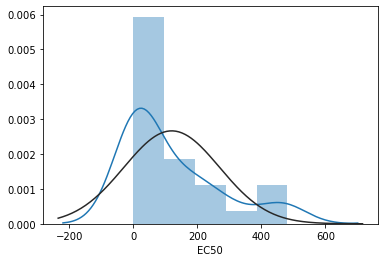

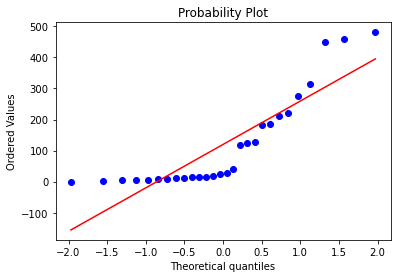

In [42]:
##########################good smiles check ahead of every mds calculation,check the smiles is good canonical smiles 
smi = mydat['smiles']
goodsmi =[]
for a in smi:
    try:
        b= Chem.CanonSmiles(a)
        goodsmi.append(b)
    except:
        print('Invalid SMILES:',a)
# goodsmi
print('no bad smiles\n')

#########################import rdkit and rdkit chem and calculate the descriptors
print('calculation of molecular descriptors\n')
from rdkit import Chem
from mordred import Calculator, descriptors
#create descriptor calculator with all descriptors including 3D descriptors，check the smiles are right with a for loop
calc=Calculator(descriptors, ignore_3D=False)
lenofmds = len(calc.descriptors)
print("descriptors number:{:5}".format(lenofmds))
#read smiles list from csv file
mols=[Chem.MolFromSmiles(smi) for smi in mydat['smiles']]
mddf = calc.pandas(mols)
#output the result
# mddf.to_csv("wmjEC50_mds.csv")

########################molecular descriptors reduction and selection
print('data reduction starts\n')
#retain molecular descriptors only contain numeric value for all molecues
print('mds data dimesion is{}\n'.format(mddf.shape))
mds2 = mddf.select_dtypes(["number"])
#remove any constant in the dataframe
#checking unique values
unique = mds2.nunique().reset_index()
unique.columns = ["colname", "unique_count"]
unique.head(10)
#columns with constant value
constant= unique[unique["unique_count"]==1]
#dropping columns with constant value
mds2.drop(columns= constant['colname'],inplace=True)
print('mds data dimesion after reduction is{}\n'.format(mds2.shape))

######################features importances searching
mds2['EC50'] = mydat['EC50']
##find the correlation of factors and respective EC50 values
correlation = mds2[mds2.columns[:]].corr()['EC50'][:]
correlation = correlation.sort_values(ascending=False)
print('thetop30posfactors: \n', correlation[1:30])  ###find the best heatmap for correlation apperance
print('thetop30negfactors: \n', correlation[-30:])

######################data split for training and test 
mds2["compound"] = mydat["ID"]
mds2['EC50'] = mydat['EC50']

from sklearn.model_selection import train_test_split
Y = mds2['EC50']
# Y = np.log(Y)
X = mds2.drop('EC50', axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

evaluationdat = pd.DataFrame()
evaluationdat['name'] = X_test['compound']
evaluationdat['EC50'] = Y_test
testID = X_test['compound']
X_train.set_index('compound', inplace=True)
X_test.set_index('compound', inplace=True)

####################check the normaality of the dataset
print('check the normaality of the dataset:\n')
from scipy.stats import norm
import seaborn as sns
from scipy import stats
sns.distplot(Y_train, fit = norm);
fig=plt.figure()
res = stats.probplot(Y_train, plot = plt)

# model construction and parameters tunning

randomforest regression construction.....

random forest parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
random forest parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
RFregression performance:

120.89001028418869
1

Text(0, 150, 'r-squred = -4.795444')

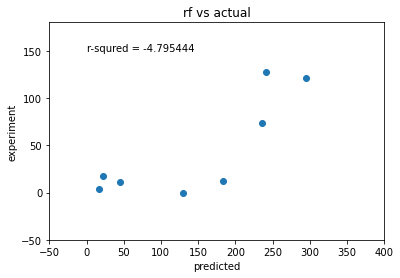

In [55]:
#################random forest feature engineering
print('randomforest regression construction.....\n')
RF = RandomForestRegressor(random_state=42, n_jobs=-1)
RF.fit(X_train,Y_train)
print('random forest parameters currently in use:\n')
pprint(RF.get_params())
from pprint import pprint
print('random forest parameters currently in use:\n')
pprint(RF.get_params())

##define metrics functions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

# def evaluate(model, features, labels):
#     predictions = model.predict(features)
#     errors = abs(predictions-labels)
#     m = 100*(errors/labels)
#     accuracy = 100-np.mean(m)
#     print('model performance')
#     print('average error:{:0.4f}degrees.'.format(np.mean(errors)))
#     print('accuracy:',round(accuracy,2),'%.')  
#     return accuracy

#prediction on random forest
RF_target = RF.predict(X_test)
print('RFregression performance:\n')
print(rmse(RF_target, Y_test))
print(mse(RF_target, Y_test))

#calculation the accuracy other than rmse
# print('RF accuracy:\n')
# valid_accuracy = evaluate(RF, X_test, Y_test)

##scatter plot for the RF regression
print('generating the scatter plots for the RF regression modeling.....\n')
y = Y_test

import os
output_path = os.path.abspath('D:/jupyter_workspace/wmj')
#random forest plots
fig,ax2 = plt.subplots()
plt.xlim(-50,400)
plt.ylim(-50,180)
ax2.scatter(RF_target,y)
ax2.set_title('rf vs actual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('experiment')
ax2.annotate('r-squred = {:3f}'.format(r2_score(y,RF_target)),(0,150))

# linear regression modeling construction

linear regression modeling constructing.....:

generating the top30 important features....

using features with importances>0.05
<class 'mordred._base.pandas_module.MordredDataFrame'>
r-square of the model:
 -3.2254161802050474


Text(0, 150, 'r-squred = -3.225416')

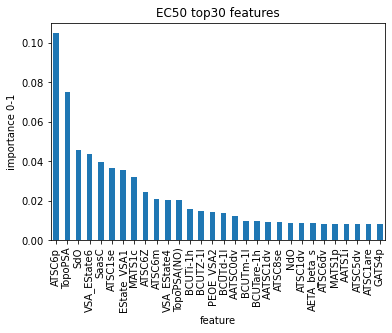

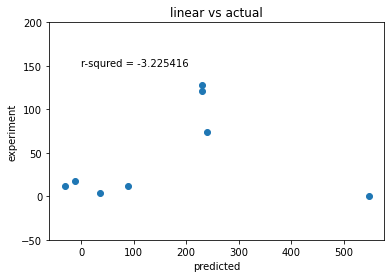

In [54]:
print('linear regression modeling constructing.....:\n')
feature_names = X_train.columns
importances=RF.feature_importances_
featuredata =  pd.DataFrame(importances,feature_names)
featuredata.columns = ['importance']
featuredata = featuredata.sort_values(by=['importance'], ascending = False)
top30 = featuredata[:30]

#barplots of all the important features
print('generating the top30 important features....\n')
output_path = 'D:/jupyter_workspace/IE-ANN/resultfigure'
top30['importance'].plot(kind='bar', title='test')
plt.title('EC50 top30 features')
plt.xlabel('feature')
plt.ylabel('importance 0-1')
outputfig = "EC50 top30 features_normalreform.jpg"
plt.savefig(os.path.join(output_path,outputfig), dpi=300, 
            quality = 80, optimize = True, progressive = True)

##use features with importances > 0.05 to make linear regression
print('using features with importances>0.05')
print(type(X_train))
X_train2 = X_train[['nAcid','NdO','FCSP3','HybRatio','SlogP_VSA2',
 'SdO','nBondsD','PEOE_VSA2','C2SP3','NaasC','C3SP2','nAromAtom',
 'nAromBond','nBondsA','naRing','n6aRing','SMR_VSA7','SlogP_VSA11','nBondsM']]
X_test2 = X_test[['nAcid','NdO','FCSP3','HybRatio','SlogP_VSA2',
 'SdO','nBondsD','PEOE_VSA2','C2SP3','NaasC','C3SP2','nAromAtom',
 'nAromBond','nBondsA','naRing','n6aRing','SMR_VSA7','SlogP_VSA11','nBondsM']]
    
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train2,Y_train)
# print(regr.intercept_)
# print(regr.coef_)

y = Y_test
regrtarget = regr.predict(X_test2)
print('r-square of the model:\n',r2_score(y,regrtarget))
    
####generating scatter plots for the linear model
output_path = os.path.abspath('D:/jupyter_workspace/wmj')
fig,ax2 = plt.subplots()
# plt.xlim(-50,500)
plt.ylim(-50,200)
ax2.scatter(regrtarget,y)
ax2.set_title('linear vs actual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('experiment')
ax2.annotate('r-squred = {:3f}'.format(r2_score(y,regrtarget)),(0,150))